In [4]:
!pip install yfinance

Defaulting to user installation because normal site-packages is not writeable
  Using cached yfinance-0.2.65-py2.py3-none-any.whl.metadata (5.8 kB)
  Using cached multitasking-0.0.12.tar.gz (19 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached peewee-3.18.2.tar.gz (949 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached curl_cffi-0.12.0-cp39-abi3-win_amd64.whl.metadata (15 kB)
Using cached yfinance-0.2.65-py2.py3-none-any.whl (119 kB)
Using cached curl_cffi-0.12.0-cp39-abi3-win_amd64.whl (1.6 MB)
   ---------------------------------------- 0.0/176.8 kB ? eta -:--:--
   ------ --------------------------------- 30.7/176.8 kB ?

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [14]:
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
# stock data for Apple Inc.
df = yf.download('AAPL', start='2015-01-01', end='2023-12-31')

C:\Users\ce1\AppData\Local\Temp\ipykernel_5640\3607227162.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('AAPL', start='2015-01-01', end='2023-12-31')
[*********************100%***********************]  1 of 1 completed


In [7]:
df.head()

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2015-01-02,24.288578,24.757332,23.848704,24.746224,212818400
2015-01-05,23.604336,24.137516,23.417723,24.057539,257142000
2015-01-06,23.606558,23.866483,23.244438,23.668762,263188400
2015-01-07,23.937574,24.037545,23.704307,23.815387,160423600
2015-01-08,24.857307,24.915069,24.148621,24.266367,237458000


In [8]:
df.isnull().sum()

Price   Ticker
Close   AAPL      0
High    AAPL      0
Low     AAPL      0
Open    AAPL      0
Volume  AAPL      0
dtype: int64

In [9]:
df.dropna(inplace=True) 

In [10]:
df.reset_index(inplace=True)

In [12]:
df = df[['Date', 'Close']]

In [13]:
df.head()

Price,Date,Close
Ticker,,AAPL
0,2015-01-02,24.288578
1,2015-01-05,23.604336
2,2015-01-06,23.606558
3,2015-01-07,23.937574
4,2015-01-08,24.857307


In [15]:
scaler = MinMaxScaler(feature_range=(0, 1))
df['Close_scaled'] = scaler.fit_transform(df[['Close']])

In [16]:
df.head()

Price,Date,Close,Close_scaled
Ticker,,AAPL,
0,2015-01-02,24.288578,0.020686
1,2015-01-05,23.604336,0.016798
2,2015-01-06,23.606558,0.016811
3,2015-01-07,23.937574,0.018691
4,2015-01-08,24.857307,0.023917


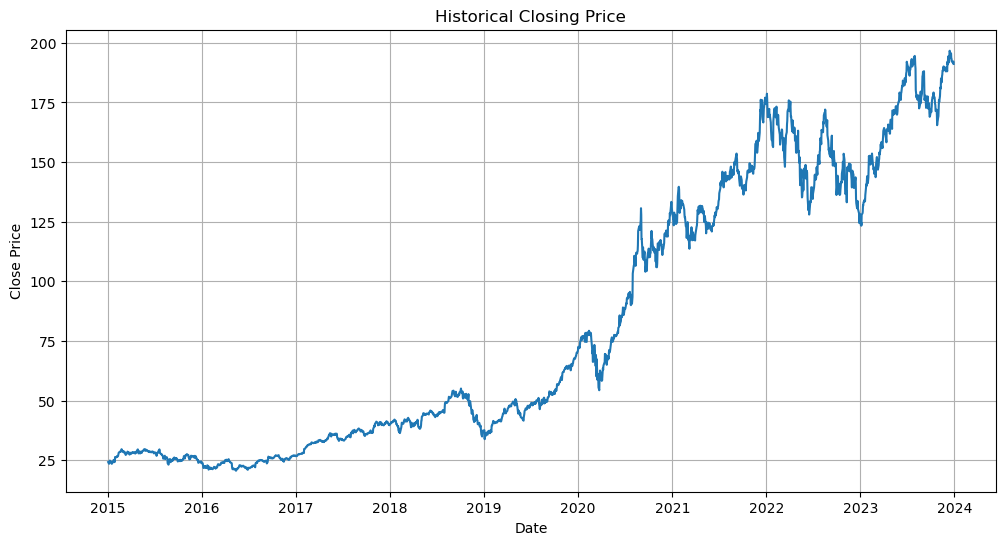

In [18]:
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Close'])
plt.title('Historical Closing Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)
plt.show()

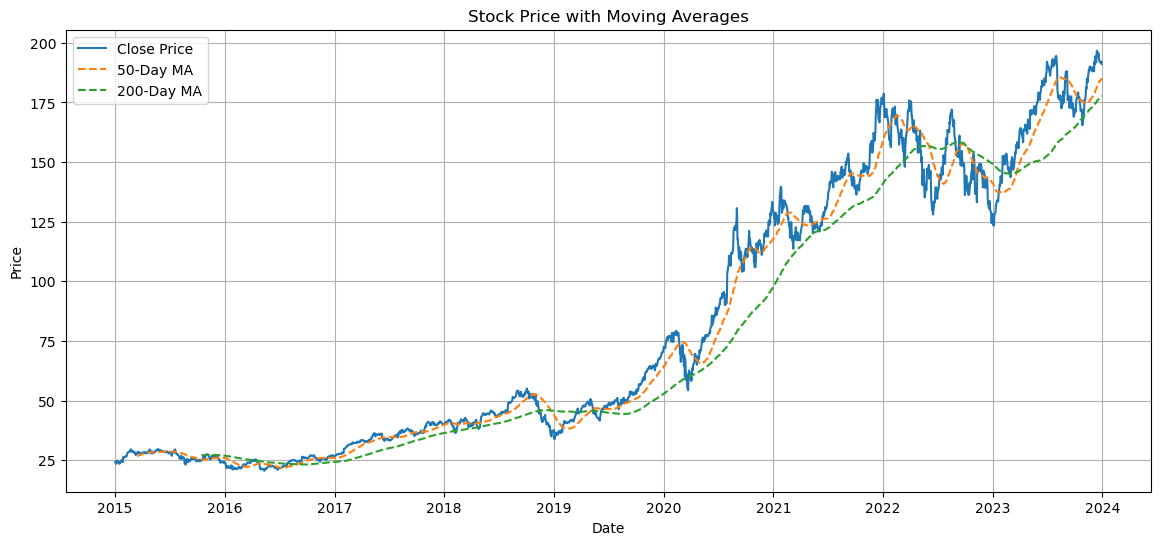

In [20]:
# moving average

df['MA50'] = df['Close'].rolling(window=50).mean()
df['MA200'] = df['Close'].rolling(window=200).mean()

plt.figure(figsize=(14, 6))
plt.plot(df['Date'], df['Close'], label='Close Price')
plt.plot(df['Date'], df['MA50'], label='50-Day MA', linestyle='--')
plt.plot(df['Date'], df['MA200'], label='200-Day MA', linestyle='--')
plt.title('Stock Price with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

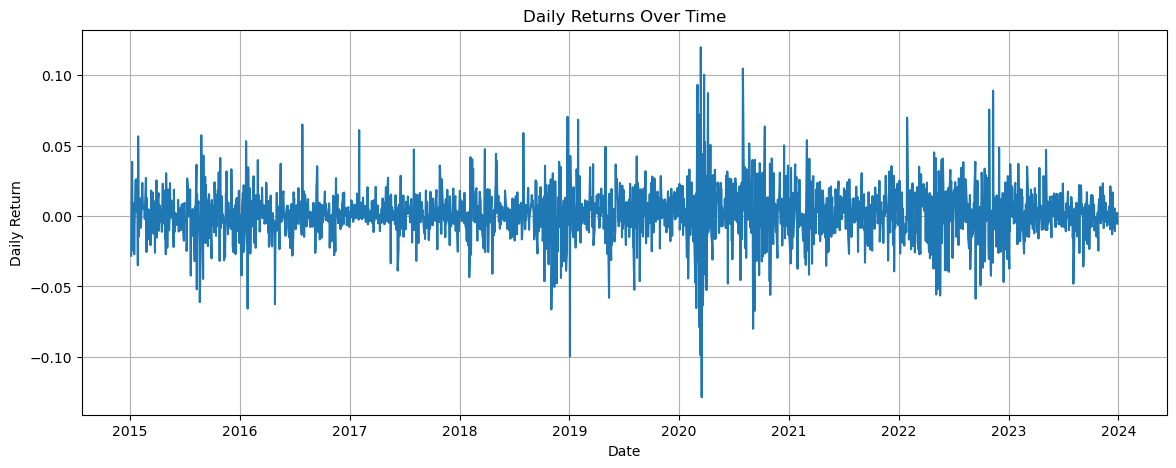

In [21]:
# daily return

df['Daily Return'] = df['Close'].pct_change()

plt.figure(figsize=(14, 5))
plt.plot(df['Date'], df['Daily Return'])
plt.title('Daily Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.grid(True)
plt.show()

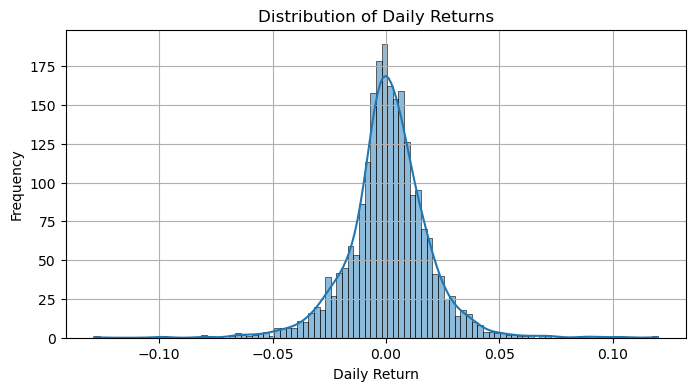

In [23]:
# returns distribution

plt.figure(figsize=(8, 4))
sns.histplot(df['Daily Return'].dropna(), bins=100, kde=True)
plt.title('Distribution of Daily Returns')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [25]:
# feature engineering

data = df['Close_scaled'].values
window_size = 60

X = []
y = []

for i in range(window_size, len(data)):
    X.append(data[i-window_size:i])
    y.append(data[i])

X = np.array(X)
y = np.array(y)

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (2204, 60)
Shape of y: (2204,)


In [26]:
X = X.reshape((X.shape[0], X.shape[1], 1))

In [30]:
# splitting now

train_size = int(len(X) * 0.8)

X_train = X[:train_size]
y_train = y[:train_size]

X_test = X[train_size:]
y_test = y[train_size:]

print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (1763, 60, 1) (1763,)
Testing set shape: (441, 60, 1) (441,)


In [32]:
model = Sequential()

In [33]:
# 1st lstm layer

model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))

C:\Users\ce1\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# 2nd lstm layer

model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

In [35]:
# output layer

model.add(Dense(units=1))

In [36]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [37]:
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 72ms/step - loss: 0.0338 - val_loss: 0.0016
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - loss: 0.0019 - val_loss: 0.0014
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - loss: 0.0014 - val_loss: 0.0033
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 0.0013 - val_loss: 0.0029
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 0.0014 - val_loss: 0.0073
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - loss: 0.0011 - val_loss: 0.0038
Epoch 9/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.0011 - val_loss: 0.0044
Epoch 10/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 11/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 12/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 0.

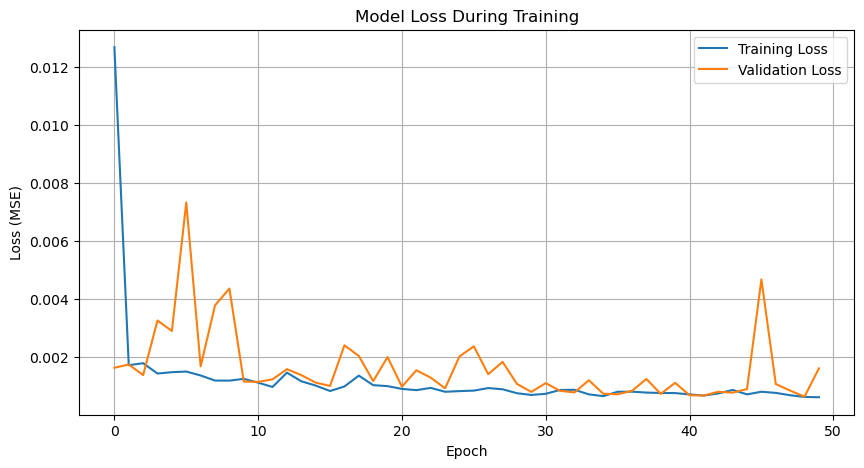

In [38]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

In [39]:
predictions = model.predict(X_test)

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step


In [40]:
predictions_unscaled = scaler.inverse_transform(predictions)
y_test_unscaled = scaler.inverse_transform(y_test.reshape(-1, 1))

In [42]:
mae = mean_absolute_error(y_test_unscaled, predictions_unscaled)
rmse = np.sqrt(mean_squared_error(y_test_unscaled, predictions_unscaled))

In [43]:
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

MAE: 6.15
RMSE: 7.06


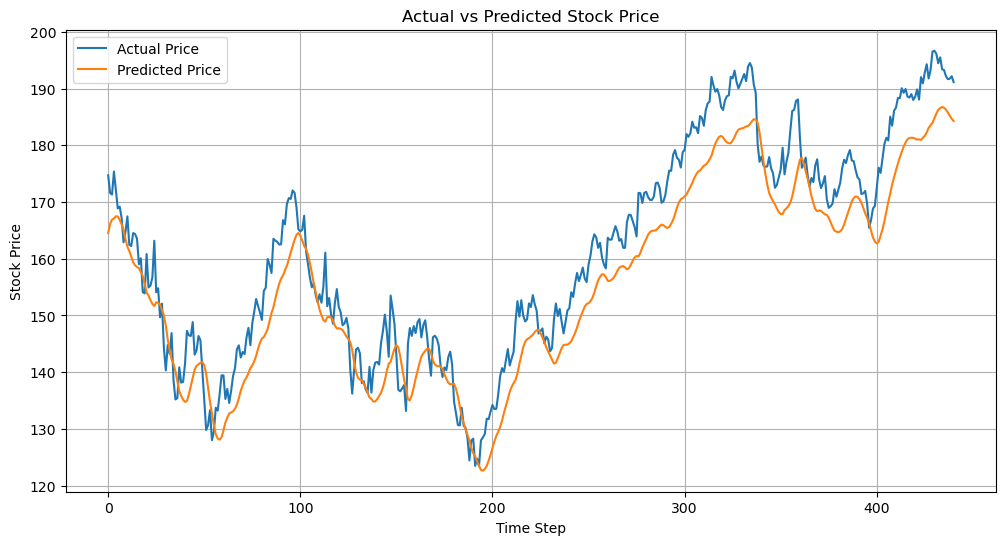

In [44]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_unscaled, label='Actual Price')
plt.plot(predictions_unscaled, label='Predicted Price')
plt.title('Actual vs Predicted Stock Price')
plt.xlabel('Time Step')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()